In [1]:
################################################################
# Import Python Libraries
################################################################
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

from Configure.Constants  import *
from Configure.AtomicData import *
from Configure.PlanetData  import *
from Configure.Conversions import amu2GeV

# Capture rate computation without darkphoton

Here we will tweak the DarkCapPy code to compute the capture rate assuming a constant cross-section for the $\chi$-SM scattering.

$\sigma^{SI} = 10^{-42} cm^2$


### Third attempt

We'll go for the same code as the first attempt.

One thing that annoyed me in the way we computed the capture rate in the first attempt, was the fact that the cross section between DM and SM should depend on the amount of nucleon in the element that we consider.

In the first attempt, the cross section was the same for every element, and I could not get my head around the fact that to me, more nucleon means a larger cross section.

Following Wikström and Edsjö's standard calculation, we can express the spin-independent cross section on a nucleus with atomic number A as : (https://arxiv.org/abs/0903.2986v2)

\begin{equation}
    \sigma^{SI}_{\chi A} = \sigma^{SI}A^2\frac{(m_\chi m_A)^2}{(m_\chi + m_A)^2}\frac{(m_\chi + m_p)^2}{(m_\chi m_p)^2} =  \sigma^{SI}A^2\left(\frac{m_\chi + m_p}{m_\chi + m_A}\frac{m_A}{m_p}\right)^2
\end{equation}

where $m_p$ is the proton mass

Let's try it out :


In [3]:
def crossSection(element, mx) :
    A = atomicNumbers[element]
    sigma = 1e-42
    mp = 0.938272
    ma = amu2GeV(A)
    
    crossSection = sigma * A **2 * ((mx + mp) * ma / (mx + ma ) / mp) **2
    
    return crossSection

Because the cross section does not depend on the velocity nor the radius at which we evaluate it, we can easily reuse the data we got from the first try which was given by :

In [110]:

# import os                                          | Reference: https://stackoverflow.com/questions/779495/python-access-data-in-package-subdirectory
# this_dir, this_filename = os.path.split(__file__)  | This was a hack for importing the branching ratio inside of this file. 
# DATA_PATH = os.path.join(this_dir, "brtoe.csv")    | It is not presently needed, but may be useful in the future. 



################################################################
# Capture Rate Functions
################################################################

sigma = 1e-42 # constant cross-section





########################
# Kinematics
########################
def eMin(u, m_X):
	'''
	eMin(u, m_X)

	Returns the minimum kinetic energy to become Gravitationally captured by Earth

	[m_X] = GeV
	'''

	function = (0.5) * m_X * u**2
#     assert (function >=0), '(u, m_X): (%e,%e) result in a negative eMin' % (u, m_X)
	return function

def eMax(element, m_X, rIndex, u):
	'''
	eMax(element, m_X, rIndex, u)

	Returns the maximum kinetic energy allowed by the kinematics

	[m_X] = GeV

	rIndex specifies the index in the escape velocity array escVel2_List[rIndex]
	'''

	m_N = amu2GeV(atomicNumbers[element])
	mu = m_N*m_X / (m_N + m_X)
	vCross2 = (escVel2_List[rIndex])
	function = 2 * mu**2 * (u**2 + vCross2) / m_N
#     assert (function >= 0), '(element, m_X, rIndex, u): (%s, %e, %i, %e) result in negative eMax' %(element, m_X, rIndex, u)
	return function




########################
# Intersection Velocity
########################
def EminEmaxIntersection(element, m_X, rIndex):
	'''
	EminEmaxIntersection(element, m_X, rIndex):

	Returns the velocity uInt when eMin = eMax.

	[m_X] = GeV

	'''
	m_N = amu2GeV(atomicNumbers[element])
	mu = (m_N*m_X)/(m_N+m_X)

	sqrtvCross2 = np.sqrt(escVel2_List[rIndex])
	# Calculate the intersection uInt of eMin and eMax given a specific rIndex
	A = m_X/2. 
	B = 2. * mu**2 / m_N
	print(m_X, A, B, mu, m_N)
	uInt = np.sqrt( ( B ) / (A-B) ) * sqrtvCross2

	return uInt




########################
# Photon Velocity and Energy Integration
########################
def intDuDEr(element, rIndex, m_X):
	'''
	intDuDER(element, m_X, rIndex):

	Returns the evaluated velocity and recoil energy integrals for dark photon scattering

	[m_X] = GeV
	'''
    
	def integrand(u):
		fu = fCrossInterp(u)
		integrand = u * fu * (u **2 + escVel2_List[rIndex]) * 1e-42

		return integrand

	# Calculate the intersection uInt of eMin and eMax given a specific rIndex
	uInt = EminEmaxIntersection(element, m_X, rIndex)

	uLow = 0
	uHigh = min(uInt, V_gal) # We take the minimal value between the intersection velocity and galactic escape velocity
	integral = integrate.quad(integrand, uLow, uHigh)[0]
	return integral



In this case, we do not want that 1e-42 to appear in the calculation. So we can simply multiply all previously computed values by 1e42.

In [4]:
mx = np.logspace(1, 2, 20)

In [8]:
sumOverRadi = pd.read_csv('data/NP1sumOverRadi', index_col = 0)*1e42
sumOverRadi

,O16,Na,Mg,Al,Si,P,S,Ca,Cr,Fe,Ni
0,4.149594e+41,1.576543e+38,1.046737e+40,5.863639e+38,5.437926e+39,2.657277e+37,1.842081e+38,1.237600e+38,2.044214e+37,1.247996e+39,6.241012e+37
1,1.632302e+42,2.984075e+38,1.903307e+40,9.738858e+38,8.824612e+39,4.146362e+37,2.784913e+38,1.722399e+38,2.669958e+37,1.608103e+39,7.972697e+37
2,1.346273e+43,6.534525e+38,3.935056e+40,1.776240e+39,1.559989e+40,6.958211e+37,4.484800e+38,2.496655e+38,3.578628e+37,2.120270e+39,1.040281e+38
3,4.181565e+44,1.782523e+39,9.822176e+40,3.688235e+39,3.099771e+40,1.286894e+38,7.846885e+38,3.809387e+38,4.950811e+37,2.874766e+39,1.392631e+38
4,1.585547e+44,7.030672e+39,3.317945e+41,9.266762e+39,7.288857e+40,2.725195e+38,1.536858e+39,6.208470e+38,7.122945e+37,4.033910e+39,1.923742e+38
5,6.408989e+42,5.833855e+40,1.972507e+42,3.165505e+40,2.228482e+41,7.053228e+38,3.536557e+39,1.103869e+39,1.076552e+38,5.907632e+39,2.762616e+38
6,1.033733e+42,1.788781e+42,4.428243e+43,1.925672e+41,1.085799e+42,2.531809e+39,1.043263e+40,2.211276e+39,1.733027e+38,9.132401e+39,4.165511e+38
7,2.998570e+41,6.615151e+41,1.449995e+44,4.562530e+42,1.478789e+43,1.695416e+40,4.737144e+40,5.263062e+39,3.030762e+38,1.513901e+40,6.685067e+38
8,1.187066e+41,2.701726e+40,5.359905e+42,1.328455e+43,1.300282e+44,4.002905e+41,5.318136e+41,1.641790e+40,5.932177e+38,2.753825e+40,1.164318e+39
9,5.696784e+40,4.377793e+39,6.134969e+41,4.537172e+41,1.203803e+43,4.914200e+41,4.429260e+42,8.322964e+40,1.363919e+39,5.695679e+40,2.265964e+39


Now we need to take the cross section in account, before we sum on all elements.
We simply multiply the capture rate per element found in try 1 by the cross section between DM and this element.

In [14]:
def singleElementCap(element, m_X):
	'''
	singleElementCap(element, m_X)

	Returns the capture rate due to a single element for the specified parameters

	[m_X] = GeV
	'''
	n_X = 0.3/m_X # GeV/cm^3

	conversion = (5.06e13)**-3 * (1.52e24) # Conversion to seconds (cm^-3)(GeV^-2) -> (s^-1)
	prefactors = (4*np.pi)**2
	function = n_X * conversion * prefactors * sumOverRadi[element][np.where(mx == m_X)[0]] * crossSection(element, m)
	return function

In [15]:
########################
# Full Capture Rate
########################
def cCap(m_X):
	'''
	cCap(m_X, m_A, epsilon, alpha, alpha_X)

	returns the full capture rate in sec^-1 for the specified parameters

	Note: This function is the less efficient way to perform this calculation. Every point in (m_A, epsilon) space 
		involves peforming the full tripple integral over recoil energy, incident DM velocity, and Earth radius
		which is time consuming.

	[m_X] = GeV
	'''
	totalCap = 0
	for element in element_List:
		elementCap = singleElementCap(element, m_X)
		print ('Element:', element,',' 'Cap: ', elementCap)
		totalCap += elementCap 
	return totalCap


And now we can compute the total capture rate very quickly

In [17]:
capNoPhoton = np.empty_like(mx)

In [18]:
for i, m in enumerate(mx) :
    capNoPhoton[i] = cCap(m)


Element: O16 ,Cap:  0    2.890726e-13
Name: O16, dtype: float64
Element: Na ,Cap:  0    2.941821e-16
Name: Na, dtype: float64
Element: Mg ,Cap:  0    2.183992e-14
Name: Mg, dtype: float64
Element: Al ,Cap:  0    1.659905e-15
Name: Al, dtype: float64
Element: Si ,Cap:  0    1.689515e-14
Name: Si, dtype: float64
Element: P ,Cap:  0    9.835697e-17
Name: P, dtype: float64
Element: S ,Cap:  0    8.018309e-16
Name: S, dtype: float64
Element: Ca ,Cap:  0    9.326075e-16
Name: Ca, dtype: float64
Element: Cr ,Cap:  0    2.875817e-16
Name: Cr, dtype: float64
Element: Fe ,Cap:  0    2.086580e-14
Name: Fe, dtype: float64
Element: Ni ,Cap:  0    1.177322e-15
Name: Ni, dtype: float64
Element: O16 ,Cap:  1    1.138312e-12
Name: O16, dtype: float64
Element: Na ,Cap:  1    5.689501e-16
Name: Na, dtype: float64
Element: Mg ,Cap:  1    4.066862e-14
Name: Mg, dtype: float64
Element: Al ,Cap:  1    2.840547e-15
Name: Al, dtype: float64
Element: Si ,Cap:  1    2.830044e-14
Name: Si, dtype: float64
Element:

Name: Al, dtype: float64
Element: Si ,Cap:  15    2.403675e-14
Name: Si, dtype: float64
Element: P ,Cap:  15    2.582463e-16
Name: P, dtype: float64
Element: S ,Cap:  15    3.781350e-15
Name: S, dtype: float64
Element: Ca ,Cap:  15    4.098811e-14
Name: Ca, dtype: float64
Element: Cr ,Cap:  15    5.203754e-13
Name: Cr, dtype: float64
Element: Fe ,Cap:  15    1.932490e-10
Name: Fe, dtype: float64
Element: Ni ,Cap:  15    4.872185e-11
Name: Ni, dtype: float64
Element: O16 ,Cap:  16    1.189178e-15
Name: O16, dtype: float64
Element: Na ,Cap:  16    4.692453e-17
Name: Na, dtype: float64
Element: Mg ,Cap:  16    5.019305e-15
Name: Mg, dtype: float64
Element: Al ,Cap:  16    1.023422e-15
Name: Al, dtype: float64
Element: Si ,Cap:  16    1.407829e-14
Name: Si, dtype: float64
Element: P ,Cap:  16    1.451629e-16
Name: P, dtype: float64
Element: S ,Cap:  16    2.030296e-15
Name: S, dtype: float64
Element: Ca ,Cap:  16    1.720182e-14
Name: Ca, dtype: float64
Element: Cr ,Cap:  16    1.018989e-1

And plot it !

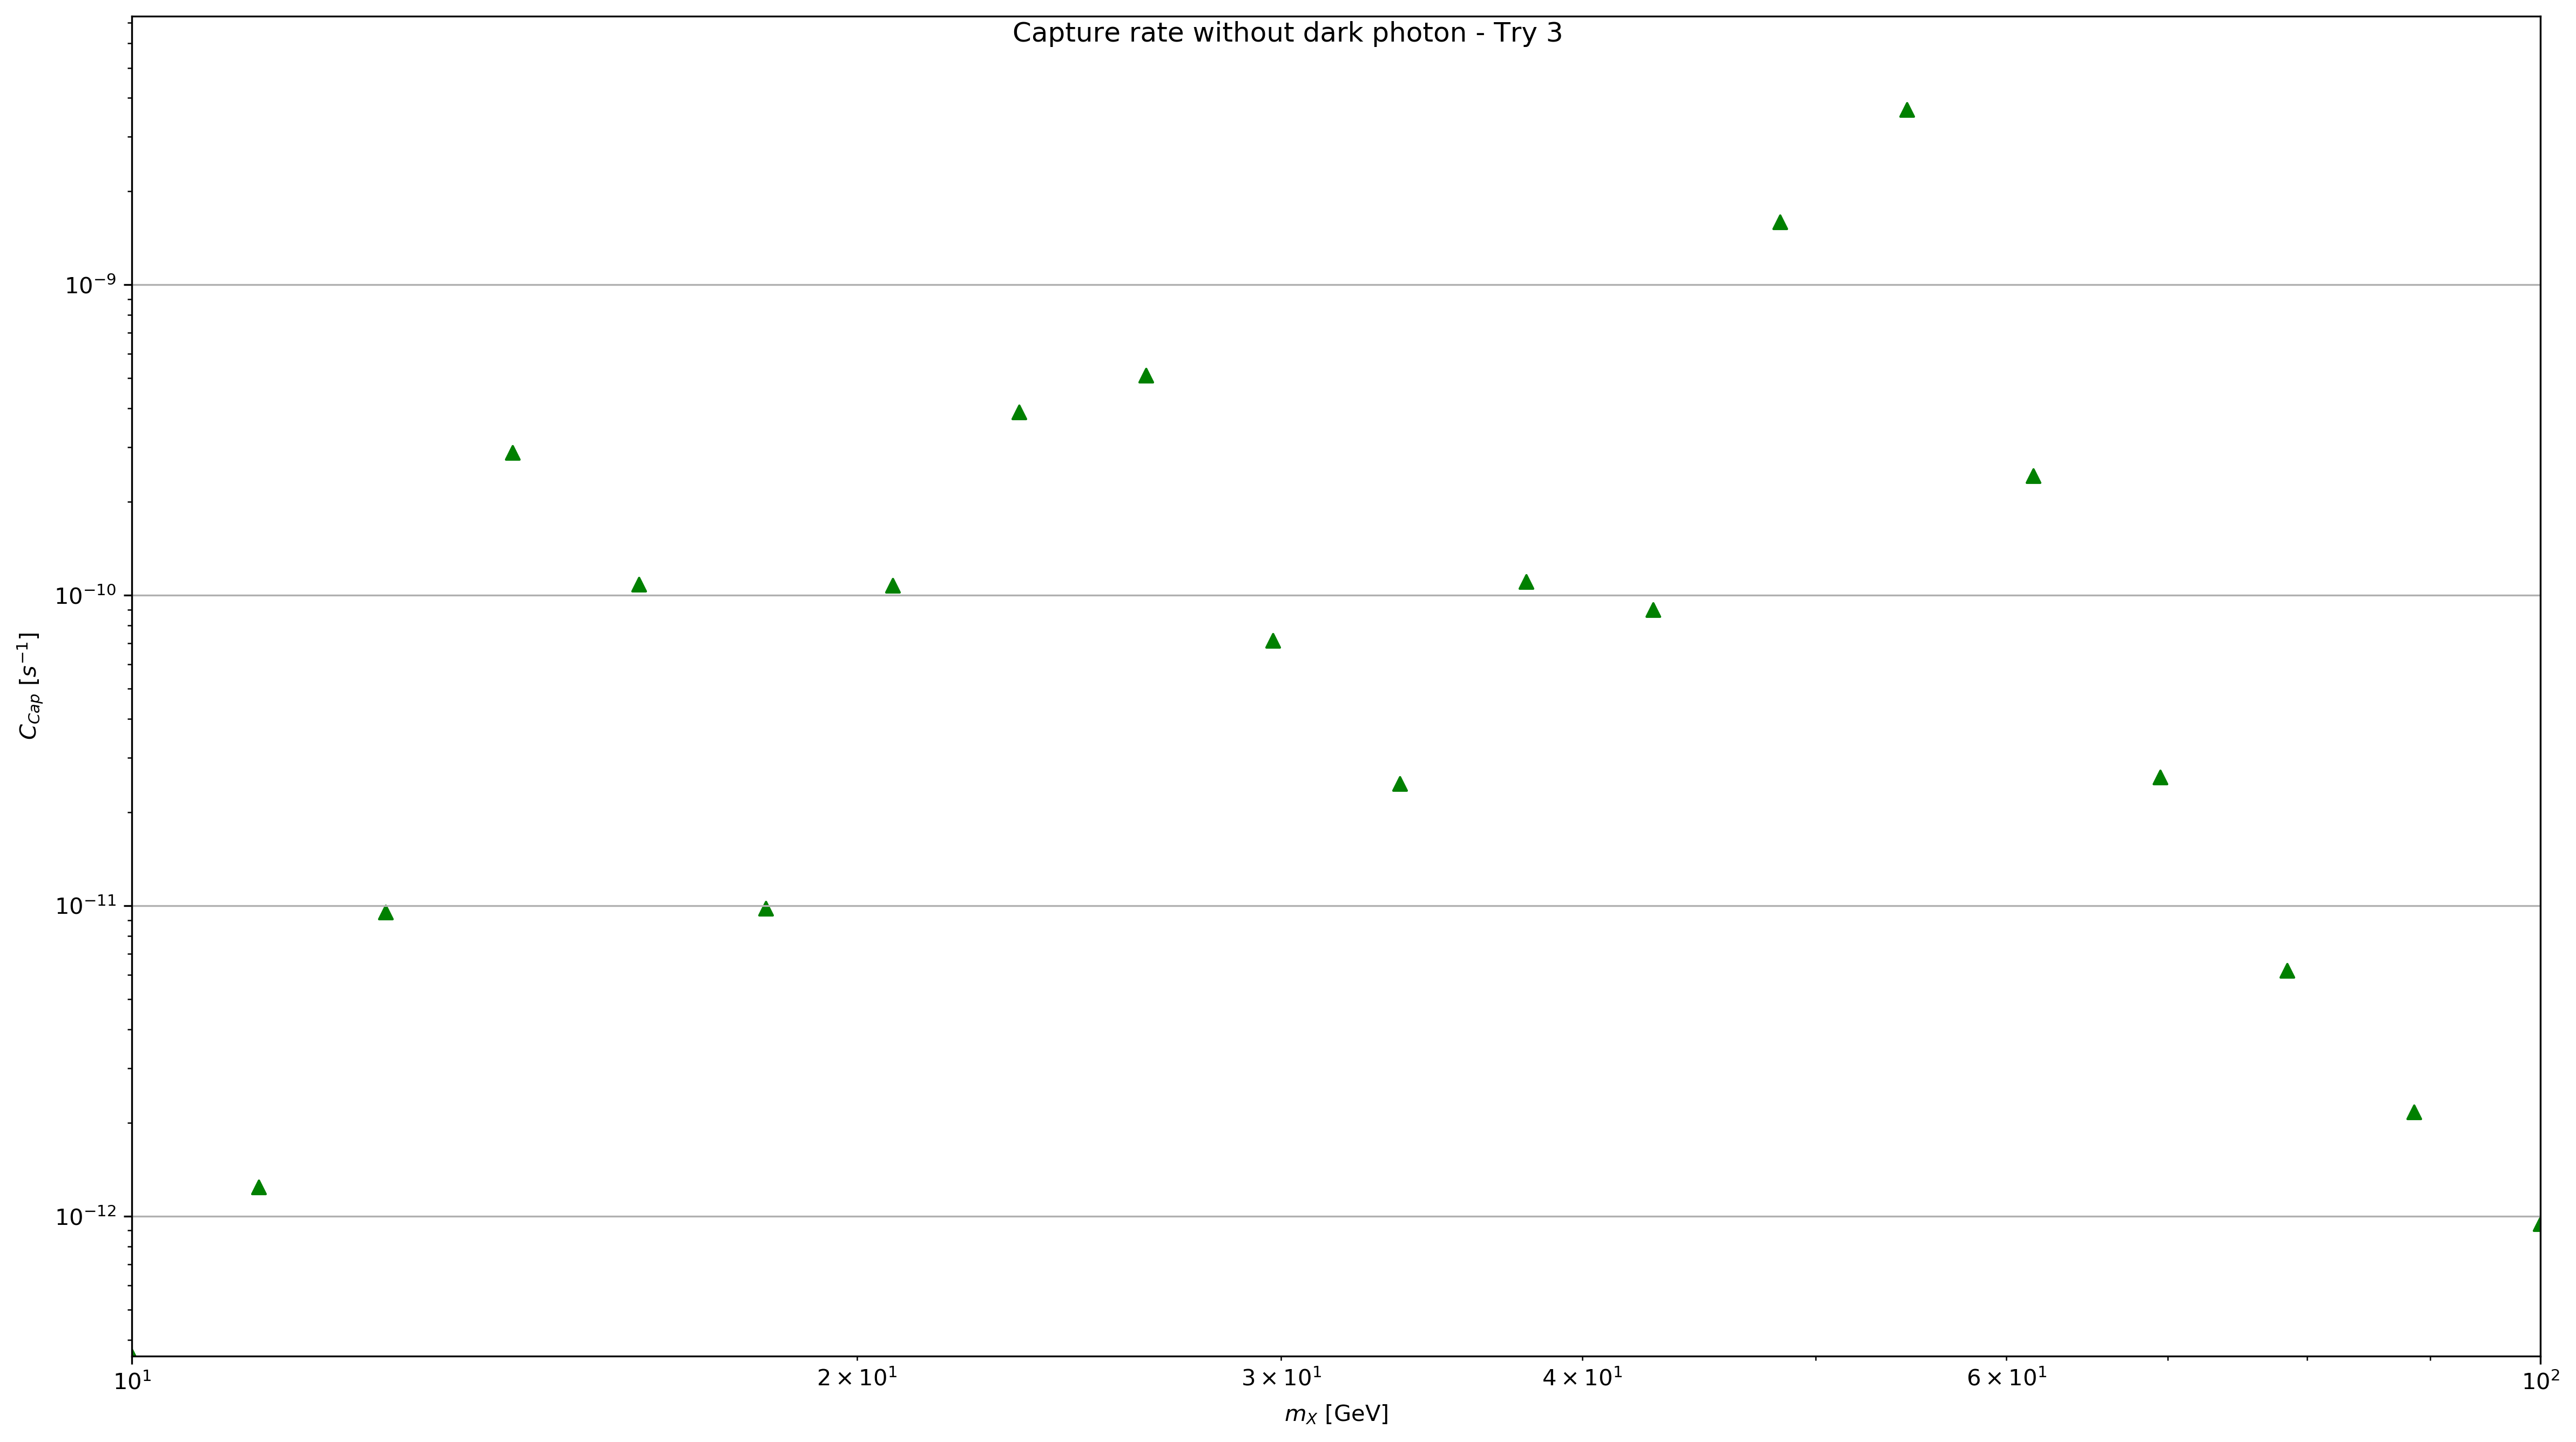

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (16, 9), dpi = 300)

ax.scatter(mx, capNoPhoton, marker = '^', color = 'g')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10, 100)
ax.set_ylim(np.amin(capNoPhoton), np.amax(capNoPhoton)*2)
ax.grid()

ax.set_ylabel('$C_{Cap}$ [$s^{-1}$]')
ax.set_xlabel('$m_X$ [GeV]')

fig.suptitle("Capture rate without dark photon - Try 3")
fig.tight_layout()

In [21]:
fig.savefig("data/Capture_rate_NP3")

This looks way better !

Now I'm confident enough that the calculation is right, and I'll compute capture rate values for the whole mx range from 10 to 10000 GeV
